In [ ]:
# # Install all important libraries
# !pip install yfinance
# !pip install ta

In [ ]:
# SGX list Dont run
list = ["C52.SI", "T39.SI", "S68.SI", "G13.SI", "V03.SI" , "U11.SI", "C07.SI" , "D05.SI", "Z74.SI",\
        "D01.SI", "O39.SI", "S63.SI", "A17U.SI" , "BN4.SI","BS6.SI", "M44U.SI", "C31.SI", "H78.SI", \
        "Y92.SI", "C38U.SI", "U14.SI", "N2IU.SI" , "F34.SI" , "C09.SI" , "J36.SI", "S58.SI" , "C6L.SI", "J37.SI", "U96.SI" ,"1810.HK"]

In [2]:
# import all libraries

from ta.utils import dropna
from ta.volatility import BollingerBands
from ta.trend import ADXIndicator
from ta.volatility import AverageTrueRange
from ta.trend import SMAIndicator
from ta.momentum import RSIIndicator
from ta.volume import VolumeWeightedAveragePrice

import math
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt


**MA Crossover strategy:**

---



Long term / Slow
Short Term / Fast

Rules --> Variables --> Parameters

Rule --> Short Term Moving average Crosses a Long term Moving average
Variables --> Short MA / Long MA
Parameters --> 5 and 21


In [93]:
# Making a class for the strategy
# init method to construct and provide all the variables that will be required by the strategy

class MA_Crossover():

  def __init__(self, symbol, start, end, STMA_window, LTMA_window, interval):

    self.symbol = symbol
    self.STMA_window = STMA_window
    self.LTMA_window= LTMA_window
    self.start = start
    self.end = end
    self.interval = interval
    self.prepare_data()


  def prepare_data(self):

    stock_data = yf.Ticker(self.symbol)
    hist_stock = stock_data.history(start = self.start, end = self.end, interval = self.interval)

    indicator_1 = SMAIndicator(close = hist_stock["Close"], window = self.STMA_window, fillna= False)
    STMA = indicator_1.sma_indicator()

    indicator_2 = SMAIndicator(close = hist_stock["Close"], window = self.LTMA_window, fillna= False)
    LTMA = indicator_2.sma_indicator()

    bt_data = pd.DataFrame()
    bt_data["Close_Price"] = hist_stock["Close"]
    bt_data["STMA"] = STMA
    bt_data["LTMA"] = LTMA
    bt_data = bt_data.dropna()
    self.data = bt_data

  def strategy(self):
    bt_data = self.data.copy()
    bt_data["Position"] = np.where(bt_data['STMA'] > bt_data['LTMA'], 1.0, -1.0)
    bt_data["Signal"] = bt_data['Position'].diff()
    bt_data = bt_data.dropna()

    bt_data['Stock_Returns'] = np.log(bt_data["Close_Price"] / bt_data["Close_Price"].shift(1))
    bt_data["Strategy_Returns"] = bt_data["Stock_Returns"] * bt_data["Position"].shift(1)
    bt_data['Cumulative_Strategy_Returns'] = bt_data['Strategy_Returns'].cumsum()

    # Getting Benchmark
    bt_data['Benchmark'] = yf.Ticker('SPY').history(start = self.start, end = self.end, interval = self.interval)['Close']
    bt_data['Benchmark_Returns'] = bt_data['Benchmark'].pct_change()
    annualized_regular_return = bt_data['Benchmark_Returns'].mean() * 252
    annualized_regular_std = bt_data['Benchmark_Returns'].std() * np.sqrt(252)

    # Calculate Beta
    cov_matrix = np.cov(bt_data['Strategy_Returns'][1:], bt_data['Benchmark_Returns'][1:])
    beta = cov_matrix[0, 1] / cov_matrix[1, 1]
    self.beta = beta

    # Calculate Alpha (assuming risk-free rate = 0)
    market_return = bt_data['Benchmark_Returns'].mean() * 252
    strategy_return = bt_data['Strategy_Returns'].mean() * 252
    alpha = strategy_return - (beta * market_return)
    self.alpha = alpha

    # Sharpe Ratio (assuming risk-free rate = 0)
    sharpe_ratio = annualized_regular_return / annualized_regular_std
    self.sharpe_ratio = sharpe_ratio

    # Sortino Ratio
    bt_data['Negative_Returns'] = bt_data[bt_data['Strategy_Returns']<0]['Strategy_Returns']
    annualized_negative_sd = bt_data['Negative_Returns'].std() * np.sqrt(252)
    sortino_ratio = annualized_regular_return / annualized_negative_sd
    self.sortino_ratio = sortino_ratio

    # Maximum Drawdown
    bt_data['Running Max'] = bt_data['Strategy_Returns'].cummax()
    bt_data['Drawdown'] = bt_data['Running Max'] - bt_data['Strategy_Returns']
    max_drawdown = bt_data['Drawdown'].max()
    zero_periods = bt_data['Drawdown'][bt_data['Drawdown'] == 0]
    delta_values = zero_periods.index[1:] - zero_periods.index[:-1]
    max_drawdown_duration = delta_values.max()
    self.max_drawdown = max_drawdown
    self.max_drawdown_duration = max_drawdown_duration

    # Treymor
    treymor_ratio = annualized_regular_return / beta
    self.treymor_ratio = treymor_ratio

    # Calmar ratio
    calmar_ratio = annualized_regular_return / max_drawdown
    self.calmar_ratio = calmar_ratio

    # Information ratio
    average_of_difference = (bt_data['Strategy_Returns'] - bt_data['Benchmark_Returns']).mean()
    std_of_difference = (bt_data['Strategy_Returns'] - bt_data['Benchmark_Returns']).std()
    information_ratio_daily = average_of_difference / std_of_difference
    information_ratio = information_ratio_daily * np.sqrt(252)
    self.information_ratio = information_ratio

    # Update
    self.data = bt_data
    self.visualise_data = bt_data

  def visualise_strategy(self):
    bt_data = self.data
    plt.title("Strategy Visualised")
    plt.plot(bt_data['LTMA'])
    plt.plot(bt_data['STMA'])
    plt.plot(bt_data['Close_Price'])

  def performance(self):
    print('Alpha', self.alpha)
    print('Beta', self.beta)
    print('Sharpe Ratio', self.sharpe_ratio)
    print('Sortino Ratio', self.sortino_ratio)
    print('Max Drawdown Duration', self.max_drawdown_duration)
    print('Max Drawdown', self.max_drawdown)
    print('Treymor Ratio', self.treymor_ratio)
    print('Calmar Ratio', self.calmar_ratio)
    print('Information Ratio', self.information_ratio)


  def returns_plot(self):
    bt_data = self.data
    plt.figure(figsize=(8, 6))
    plt.plot(bt_data['Stock_Returns'].cumsum(), label='Stock Returns', color='blue')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Stock Returns')
    plt.legend()
    plt.show()

  def drawdown_plot(self):
    bt_data = self.data
    bt_data["Cum_Max"] = bt_data["Cumulative_Strategy_Returns"].cummax()
    plt.figure(figsize=(8, 6))
    plt.plot(bt_data[["Cumulative_Strategy_Returns","Cum_Max"]])
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Drawdown')
    plt.legend()
    plt.show()



Alpha 0.28812110020860615
Beta -0.0404122111774197
Sharpe Ratio 0.6724187281076753
Sortino Ratio 0.6935472832562074
Max Drawdown Duration 45 days 00:00:00
Max Drawdown 0.15807089444731076
Treymor Ratio -3.3294922018405977
Calmar Ratio 0.8512138964279989
Information Ratio 0.4019007488020333


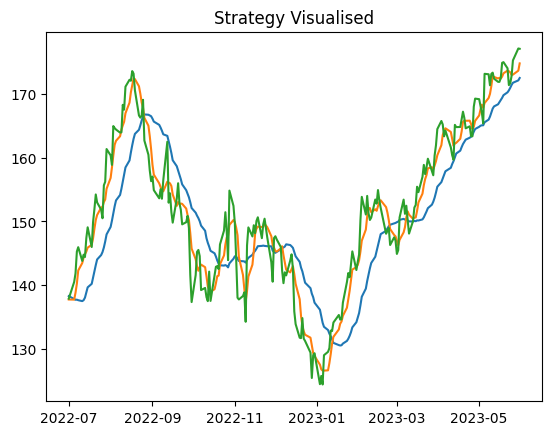

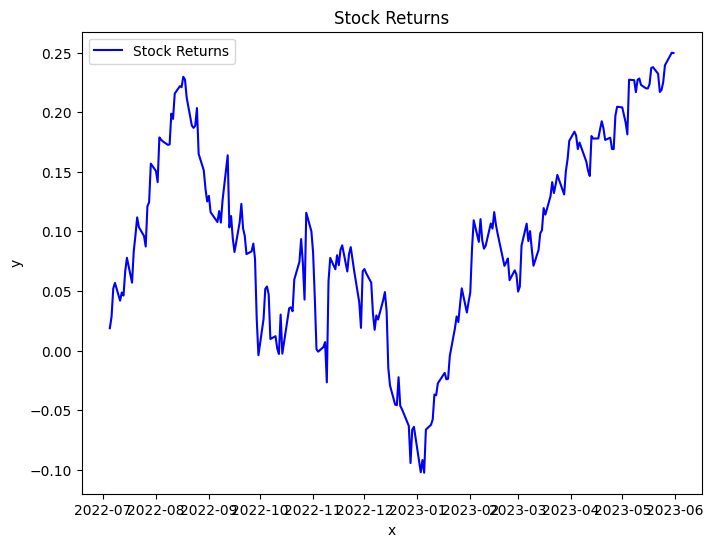

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


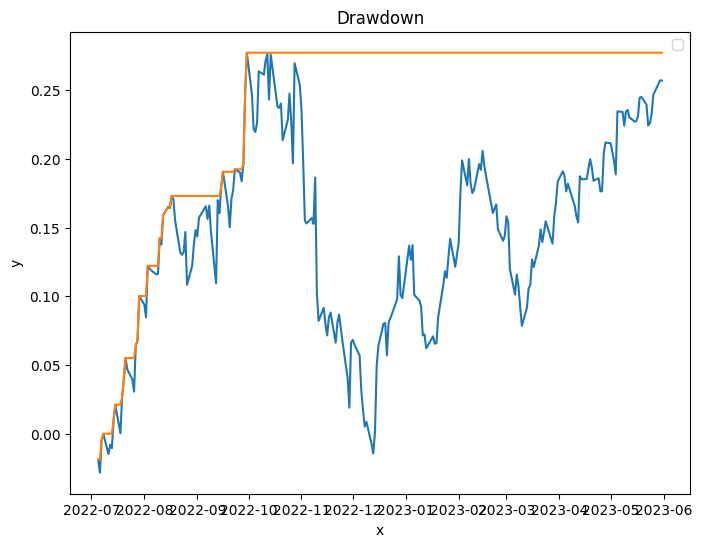

In [94]:
# main syntax is for running a single python file (.py) as a script. It is utillised by the python interpreter
# if testing in colab  or notebooks, can directly call the backtester

if __name__ == '__main__':

  # instantiate an instance of the main class Backtester
  output = MA_Crossover("AAPL", "2022-06-01", "2023-06-01", 5, 21, "1d")

  #run the strategy
  output.strategy()

  #visulaise the crossover
  output.visualise_strategy()

  # #get the performance
  output.performance()

  # #plot the returns
  output.returns_plot()

  # #plot the drawdown
  output.drawdown_plot()

In [24]:
# You can run for your desired / logical parameters and stpre the results.
# You can also optimise with different libraries but I will not suggest optimizing.